## Mount Drive

In [1]:
# # %%capture
# # prompt: mount drive
# !conda install -y gdown
# !gdown --id 1OB6oyBkCZxuOEMYXMCoMtYYLb5gxLbwm

## W&B

In [2]:
!pip install -qq -U wandb

## Imports

In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
from PIL import Image
import glob
import shutil

# Configure plot display settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import tarfile
from tqdm.notebook import tqdm
from IPython import display

# Weights and Biases related imports
import wandb
from wandb.integration.keras import WandbMetricsLogger
from wandb.integration.keras import WandbModelCheckpoint

2.16.1


In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leonardo-polverari (uniboc). Use `wandb login --relogin` to force relogin


True

## Hyperparams

In [5]:
# Define training hyperparameters
# SIAMO A 60!
epochs = 2
learning_rate = 5e-5
batch_size = 32
image_height = 256
image_width = 256
channels = 1
patch_shape = (64, 64, channels)
patch_size = 8
patch_dim = patch_size * patch_size 
# Input image dimensions
input_shape = (image_height, image_width, channels)
# Total number of patches
num_patches = (input_shape[0] // patch_size) ** 2
# Dimensionality of embedding space
embedding_dim = 64
# Number of attention heads
num_heads = 6
# Dimension of feed-forward network
ff_dim = 96
# Number of Transformer blocks
transformer_layers = 5
# Units in MLP head layers
mlp_head_units = [512, 100]
# Dropout rate for regularisation
dropout_rate = 0.1
# Stochastic depth rate for regularisation
stochastic_depth_rate = 0.1
# Dimension of a patch
patch_dim = patch_size * patch_size * input_shape[2]
latent_dim = 128
train_size = 30000
test_size = 1000

# Print current parameters
print(f"Input shape:          {input_shape}")
print(f"Patch size:           {patch_size}")
print(f"Number of patches:    {num_patches}")
print(f"Embedding dimension:  {embedding_dim}")
print(f"Number of heads:      {num_heads}")
print(f"Feed-forward dimension: {ff_dim}")
print(f"Number of Transformer layers: {transformer_layers}")
print(f"MLP head units:       {mlp_head_units}")
print(f"Patch dimension:      {patch_dim}")


# Print current parameters
print(f"Parameters defined:\n"
      f"  epochs:        {epochs:>8}\n"
      f"  learning_rate: {learning_rate:>8.1e}\n"
      f"  batch_size:    {batch_size:>8}\n"
      f"  image_height:  {image_height:>8}\n"
      f"  image_width:   {image_width:>8}\n"
      f"  channels:      {channels:>8}\n"
      f"  patch_shape:   {patch_shape}\n"
      )

Input shape:          (256, 256, 1)
Patch size:           8
Number of patches:    1024
Embedding dimension:  64
Number of heads:      6
Feed-forward dimension: 96
Number of Transformer layers: 5
MLP head units:       [512, 100]
Patch dimension:      64
Parameters defined:
  epochs:               2
  learning_rate:  5.0e-05
  batch_size:          32
  image_height:       256
  image_width:        256
  channels:             1
  patch_shape:   (64, 64, 1)



## Utils

In [6]:
# Example: Display one patched grayscale image
def display_image(image):
    # Denormalize the image to the range [0, 1] for visualization
    image = (image + 1) / 2.0
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.show()

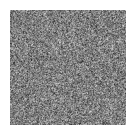

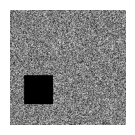

In [7]:
def apply_random_patches(image, patch_shape, return_coords = False):
    """
    Applies random patches (filled with zeros) to an image.

    Args:
        image: Tensor of shape (height, width, channels).
        patch_height: Height of the patch.
        patch_width: Width of the patch.
        num_patches: Number of patches to apply.

    Returns:
        Tensor with patches applied.
    """
    # batch_size, img_height, img_width, channels = batch_size, img_height, img_width, channels
    mask = tf.ones((image_height, image_width), dtype=tf.float32)
    patch_width, patch_height = patch_shape[:2]

    # Random top-left corner for the patch
    x_start = tf.random.uniform((), minval=0, maxval=image_width - patch_width, dtype=tf.int32)
    y_start = tf.random.uniform((), minval=0, maxval=image_height - patch_height, dtype=tf.int32)

    # Create patch mask
    patch_coords = tf.stack(tf.meshgrid(
        tf.range(y_start, y_start + patch_height),
        tf.range(x_start, x_start + patch_width),
        indexing='ij'
    ), axis=-1)
    patch_coords = tf.reshape(patch_coords, [-1, 2])  # Flatten the coordinates

    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=patch_coords,
        updates=tf.zeros(patch_height * patch_width, dtype=tf.float32)
    )

    # Add channel dimension to the mask
    mask = tf.expand_dims(mask, axis=-1)

    # Apply the mask to the image
    patched_image = image * mask
    if return_coords:
      patched_image = patched_image, patch_coords
    return patched_image

# Apply random patches
image = np.random.rand(3, 256, 256, 1)
patched_image, coords = apply_random_patches(image, patch_shape=patch_shape, return_coords = True)

# Display results
display_image(tf.squeeze(image[0]))
display_image(tf.squeeze(patched_image[0]))

In [8]:
import tensorflow as tf

def extract_fixed_patch(image, mask, patch_size=32):
    # Get mask center (mean of non-zero locations)
    mask_indices = tf.where(tf.equal(mask, 0))  # Indices of mask
    mask_center = tf.reduce_mean(tf.cast(mask_indices, tf.float32), axis=0)  # Center of mass
    
    # Compute top-left corner for cropping
    center_y, center_x = tf.cast(mask_center[0], tf.int32), tf.cast(mask_center[1], tf.int32)
    half_size = patch_size // 2
    start_y = tf.maximum(0, center_y - half_size)
    start_x = tf.maximum(0, center_x - half_size)
    
    # Crop fixed-size patch
    cropped_patch = tf.image.crop_to_bounding_box(
        image,
        offset_height=start_y,
        offset_width=start_x,
        target_height=patch_size,
        target_width=patch_size
    )
    return cropped_patch

In [9]:
def batch_extract_fixed_patch(images, masks, patch_size=16):
    def process_single_instance(inputs):
        image, mask = inputs
        return extract_fixed_patch(image, mask, patch_size)

    # Use tf.map_fn to apply the function across the batch
    patches = tf.map_fn(
        process_single_instance,
        (images, masks),
        fn_output_signature=tf.float32  # Adjust this based on your image dtype
    )
    return patches

## Stream Data

### Stream Whole Picture

In [10]:
# Function to apply patches to different sections of the image (without resizing the image after patching)
import tensorflow as tf


# Function to extract, preprocess images, convert to grayscale, and apply patching
def extract_and_preprocess_images(tar_path, patch_shape, return_inverse = False):
    """Extracts images from a tar file, converts them to grayscale, resizes them,
    and applies random patches for inpainting."""
    with tarfile.open(tar_path, 'r') as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                # Extract the image file
                f = tar.extractfile(member)
                image_data = f.read()

                # Decode and preprocess the image using TensorFlow
                image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
                image = tf.image.resize(image, [image_height, image_width])

                # Convert to grayscale
                image_gray = tf.image.rgb_to_grayscale(image)
                image_gray = (image_gray / 127.5) - 1  # Normalize to [-1, 1]

                mask = tf.ones((image_height, image_width, channels), dtype=tf.float32)
                mask = apply_random_patches(mask, patch_shape)
                inverse_mask = tf.ones((image_height, image_width, channels), dtype=tf.float32) - mask

                if return_inverse:
                    yield image_gray, mask, inverse_mask  # Yield the preprocessed image with patch
                else:
                    yield image_gray, mask

# Path to your tar file
tar_path = '/kaggle/working/artbench-10-imagefolder-split.tar'

# Convert the generator into a TensorFlow Dataset
image_dataset = tf.data.Dataset.from_generator(
    lambda: extract_and_preprocess_images(tar_path, patch_shape),
    output_signature=(
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: extract_and_preprocess_images(tar_path, patch_shape, return_inverse=True),
    output_signature=(
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32)
    )
)

# 60,000 images
image_dataset = image_dataset.shuffle(buffer_size = 1000, seed = 42)

# 40,000 for training
train_data = image_dataset.skip(test_size).take(train_size)

# 10,000 for testing
test_data = test_dataset.take(test_size)

image_dataset = image_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


input_shape = train_data.element_spec[0].shape[1:]
print(input_shape)

(256, 256, 1)


### Rest of Work

In [11]:
ex_imgs = train_data.take(1)
for img in ex_imgs:
    imgs = img

In [12]:
train_data.element_spec

(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))

## Discriminator

### Global

#### Old Global Discriminator

In [13]:
# Define a function to build the discriminator model
def get_global_discriminator(input_shape, seed=seed, name = 'global_discriminator'):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First convolutional block
    x = tfkl.Conv2D(32, 3, padding='same', strides=2, name='conv1')(input_layer)
    x = tfkl.LayerNormalization(name='ln1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    # Second convolutional block
    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.LayerNormalization(name='ln2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    # Third convolutional block
    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.LayerNormalization(name='ln3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    # Flatten the feature maps instead of applying GAP
    x = tfkl.Flatten(name='flatten')(x)
    
    # Multi-Layer Perceptron (MLP) after flattening
    x = tfkl.Dense(512, name='dense1')(x)  # Increase the number of units to capture spatial features
    x = tfkl.LayerNormalization(name='ln4')(x)  # Normalization
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    
    x = tfkl.Dense(256, name='dense2')(x)  # Add another dense layer for better feature representation
    x = tfkl.LayerNormalization(name='ln5')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation5')(x)
    
    # Final output layer
    output_layer = tfkl.Dense(1, name='dense_out')(x)


    # Return the discriminator model
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)

Input shape = (256, 256, 1)
Starting image shape = (256, 256, 1)
Discriminator Output shape = (32, 1) ! 32 because of batch


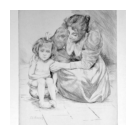

In [14]:
# QUICK CHECK
used_img = imgs[0][0]
discriminator = get_global_discriminator(input_shape)
discriminator_out = discriminator(imgs[0], training=False)
print('Input shape =', input_shape)
print('Starting image shape =', used_img.shape)
print('Discriminator Output shape =', discriminator_out.shape, f'! {batch_size} because of batch')
display_image(used_img)

### Local

In [15]:
def get_local_discriminator(input_shape, seed=seed, name='local_discriminator_with_gap'):
    # Set random seed for reproducibility
    tf.random.set_seed(seed)

    # Define input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Mask 0 Pixels to only consider generated area
    masking_layer = tfkl.Masking()(input_layer)

    # First convolutional block
    x = tfkl.Conv2D(32, 3, padding='same', strides=2, name='conv1')(masking_layer)
    x = tfkl.LayerNormalization(name='ln1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    # Second convolutional block
    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.LayerNormalization(name='ln2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    # Third convolutional block
    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.LayerNormalization(name='ln3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    # Global Average Pooling instead of Flatten
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Multi-Layer Perceptron (MLP) after GAP
    x = tfkl.Dense(512, name='dense1')(x)  # Increase the number of units to capture more complex features
    x = tfkl.LayerNormalization(name='ln4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    
    x = tfkl.Dense(256, name='dense2')(x)  # Add another dense layer for better representation
    x = tfkl.LayerNormalization(name='ln5')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation5')(x)
    
    # Final output layer
    output_layer = tfkl.Dense(1, name='dense_out')(x)

    # Return the discriminator model
    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)


Input shape = (256, 256, 1)
Starting image shape = (256, 256, 1)
Discriminator Output shape = (32, 1) ! 32 because of batch


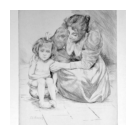

In [16]:
# QUICK CHECK
used_img = imgs[0][0]
discriminator = get_local_discriminator(input_shape)
discriminator_out = discriminator(imgs[0], training=False)
print('Input shape =', input_shape)
print('Starting image shape =', used_img.shape)
print('Discriminator Output shape =', discriminator_out.shape, f'! {batch_size} because of batch')
display_image(used_img)

## Generator (Vit)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras

# Positional Encoding (simple implementation)
@keras.saving.register_keras_serializable(package="MyGAN")
class PositionEncoding(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionEncoding, self).__init__(**kwargs)
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.range(0, seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(0, self.d_model, 2, dtype=tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (i / tf.cast(self.d_model, tf.float32)))
        angle_rads = pos * angle_rates
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
        return x + pos_encoding[tf.newaxis, ...]

    def get_config(self):
        # Correctly serialize the integer value of d_model
        base_config = super().get_config()
        config = {
            "d_model": self.d_model,
        }
        return {**base_config, **config}
        

    @classmethod
    def from_config(cls, config):
        d_model_config = config.pop('d_model')
        d_model = d_model_config
        return cls(d_model, **config)
    

# Attention Block (TSA - Transformer Style Attention)
@keras.saving.register_keras_serializable(package="MyGAN")
class TSA_Block(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(TSA_Block, self).__init__(**kwargs)
        self.d_model = d_model
        self.q_dense = layers.Dense(d_model)
        self.k_dense = layers.Dense(d_model)
        self.v_dense = layers.Dense(d_model)
        self.add = layers.Add()
        self.softmax = layers.Softmax(axis=-1)
    
    def call(self, inputs):
        # Positional Encoding
        pos_encoded = PositionEncoding(self.d_model)(inputs)
        
        # Linear projections
        q = self.q_dense(pos_encoded)
        k = self.k_dense(pos_encoded)
        v = self.v_dense(pos_encoded)
        
        # Scaled dot-product attention
        attention_logits = tf.matmul(q, k, transpose_b=True)
        attention_logits /= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        attention_weights = self.softmax(attention_logits)
        attention_output = tf.matmul(attention_weights, v)
        
        # Skip connection
        return self.add([inputs, attention_output])

    def get_config(self):
        # Correctly serialize the integer value of d_model
        base_config = super().get_config()
        config = {
            "d_model": self.d_model,
        }
        return {**base_config, **config}
        

    @classmethod
    def from_config(cls, config):
        d_model_config = config.pop('d_model')
        d_model = d_model_config
        return cls(d_model, **config)


# Grouped Convolution Block (GSA)
def GSA_Block(inputs, filters):
    conv_w = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    conv_m = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    conv_n = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    combined = layers.Multiply()([conv_w, conv_m, conv_n])
    return layers.Add()([inputs, combined])

# Encoder Block
def EncoderBlock(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    pooled = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x, pooled

# Decoder Block
def DecoderBlock(inputs, skip, filters):
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(inputs)
    x = layers.Concatenate()([x, skip])
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    return x

# Full Model
def build_model(input_shape=(256, 256, 1), channels=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    enc1, pool1 = EncoderBlock(inputs, 64)
    enc2, pool2 = EncoderBlock(pool1, 128)
    enc3, pool3 = EncoderBlock(pool2, 256)

    # Transformer Attention (TSA) + Grouped Attention (GSA)
    tsa = TSA_Block(256)(pool3)
    gsa = GSA_Block(pool3, 256)
    combined = layers.Add()([tsa, gsa])

    # Decoder
    dec3 = DecoderBlock(combined, enc3, 256)
    dec2 = DecoderBlock(dec3, enc2, 128)
    dec1 = DecoderBlock(dec2, enc1, 64)

    # Output Layer
    outputs = layers.Conv2D(channels, 1, activation="tanh")(dec1)

    return models.Model(inputs, outputs)

# Instantiate and compile the model
generator = build_model(input_shape=input_shape, channels=1)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    590,080 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    590,080 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ conv2d_3[0][0], 

 Total params: 4,073,985 (15.54 MB)

 Trainable params: 4,072,193 (15.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

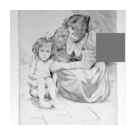

In [18]:
display_image(imgs[0][0]*imgs[1][0])

### Quick Check

Input shape = (256, 256, 1)
Starting image shape = (32, 256, 256, 1)
Generated image shape = (32, 256, 256, 1)


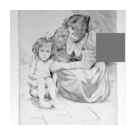

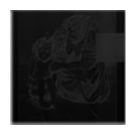

In [19]:
# QUICK CHECK
# generator = get_generator(input_shape)
generated_image = generator(imgs[0]*imgs[1], training=False)
print('Input shape =', input_shape)
print('Starting image shape =', imgs[0].shape)
print('Generated image shape =', generated_image.shape)
display_image(imgs[0][0]*imgs[1][0])
display_image(generated_image[0])

## GAN

# ATTENZIONE METTERE MSE!!!!

In [20]:
def masked_mse_loss(y_true, y_pred, mask):
    # Compute squared error
    squared_error = tf.square(y_true - y_pred)
    # Apply mask
    masked_error = squared_error * mask
    # Average over valid areas only
    return tf.reduce_sum(masked_error) / tf.reduce_sum(mask)

def masked_mae_loss(y_true, y_pred, mask):
    abs_error = tf.abs(y_true - y_pred)
    masked_error = abs_error * mask
    return tf.reduce_sum(masked_error) / tf.reduce_sum(mask)
    

In [21]:
import keras
@keras.saving.register_keras_serializable()
class GAN(tfk.Model):

    # Initialise the GAN with a discriminator, generator, latent dimension, and discriminator update frequency
    def __init__(self, local_discriminator, generator, n_discriminator_updates=3, **kwargs):
        super().__init__(**kwargs)
        self.local_discriminator = local_discriminator
        self.generator = generator
        self.n_discriminator_updates = n_discriminator_updates

        # Initialise loss trackers for discriminator and generator
        self.mae_loss_tracker = tfk.metrics.Mean(name="mae_loss")
        self.local_loss_tracker = tfk.metrics.Mean(name="local_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")
        self.local_adv_loss_tracker = tfk.metrics.Mean(name="local_adv_loss")

    # Compile the GAN with optimisers and an optional loss function
    def compile(self, local_optimizer, g_optimizer, loss_fn=None, mae_weight=0, local_weight = 1):
        super(GAN, self).compile()
        self.local_optimizer = local_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn or tfk.losses.BinaryCrossentropy(from_logits=True)
        self.mse_loss_fn = masked_mse_loss
        self.mae_loss_fn = masked_mae_loss
        self.mae_weight = mae_weight
        self.local_weight = local_weight

    def get_config(self):
        # Return all arguments passed to the __init__ method
        config = super(GAN, self).get_config()
        config.update({
            'local_discriminator': keras.saving.serialize_keras_object(self.local_discriminator),
            'generator' : keras.saving.serialize_keras_object(self.generator),
            'n_discriminator_updates' : self.n_discriminator_updates
        
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate the model from the config
        local_discriminator_config = config.pop("local_discriminator")
        local_discriminator = keras.saving.deserialize_keras_object(local_discriminator_config)
        generator_config = config.pop("generator")
        generator = keras.saving.deserialize_keras_object(generator_config)
        return cls(local_discriminator, generator, **config)

    # Define GAN metrics
    @property
    def metrics(self):
        return [self.local_loss_tracker, self.g_loss_tracker]

    def _adversarial_loss(self, fake_output, generated_images, real_images):
      adv_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
      return adv_loss

    def _mse_loss(self, generated_images, real_images, masks):
        mse_loss = self.mse_loss_fn(real_images, generated_images, masks)
        return mse_loss
        
    def _mae_loss(self, generated_images, real_images, masks):
        mse_loss = self.mae_loss_fn(real_images, generated_images, masks)
        return mse_loss
        

    # Compute discriminator loss
    def _discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    # Define the training step
    @tf.function
    def train_step(self, masked_and_real_images):

        # Train discriminator multiple times
        global_loss = 0
        local_loss = 0
        for _ in range(self.n_discriminator_updates):

            real_images = masked_and_real_images[0]
            masks = masked_and_real_images[1]
            masked_images = masks * real_images
            inverse_masks = (1 - masks)
            masked_area = inverse_masks * real_images


            with tf.GradientTape() as tape:
                # local discriminator
                global_generated_images = self.generator(masked_images, training=True)
                local_generated_images = global_generated_images * inverse_masks
                local_real_output = self.local_discriminator(masked_area, training = True)
                local_fake_output = self.local_discriminator(local_generated_images, training = True)
                current_local_loss = self._discriminator_loss(local_real_output, local_fake_output)

            # Update local discriminator weights
            grads = tape.gradient(current_local_loss, self.local_discriminator.trainable_weights)
            self.local_optimizer.apply_gradients(zip(grads, self.local_discriminator.trainable_weights))
            local_loss += current_local_loss / self.n_discriminator_updates

        # Train generator
        with tf.GradientTape() as tape:
            global_generated_images = self.generator(masked_images, training=True)
            superimposed_images = real_images * masks + global_generated_images * inverse_masks
            local_generated_images = global_generated_images * inverse_masks
            local_fake_output = self.local_discriminator(local_generated_images, training=False)
            local_adv_loss = self._adversarial_loss(local_fake_output, local_generated_images, masked_area) * self.local_weight
            mae_loss = self._mae_loss(global_generated_images, real_images, inverse_masks) * self.mae_weight
            g_loss = local_adv_loss + mae_loss

        # Update generator weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss trackers
        self.local_loss_tracker.update_state(local_loss)
        self.g_loss_tracker.update_state(g_loss)
        self.mae_loss_tracker.update_state(mae_loss)
        self.local_adv_loss_tracker.update_state(local_adv_loss)

        # Return loss metrics
        return {
            "local_loss": self.local_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
            "mae_loss": self.mae_loss_tracker.result(),
            "local_adv_loss" : self.local_adv_loss_tracker.result()
        }

### GAN MONITOR

In [22]:
import matplotlib.pyplot as plt

def plot_test_images(test_images, generator, titles=None, n_imgs = 4):
    """
    Plots the first four images from the test batch with their respective titles.

    Parameters:
        test_images (list): A list containing input images and masks for testing.
        generator (Model): The trained generator model for generating images.
        titles (list): List of titles for the images, defaulted to None.
    """
    if titles is None:
        titles = ['Original Image', 'Patched Image', 'Generated Image', 'Superimposed Image']


    fig, axes = plt.subplots(n_imgs, 4, figsize=(7, 7))
    for i in range(n_imgs):
        original_image = test_images[0][i]
        patched_image = test_images[0][i] * test_images[1][i]
        generated_image = generator(test_images[0] * test_images[1]).numpy()[i]
        inverse_mask = test_images[2][i]
        superimposed_image = patched_image + (inverse_mask * generated_image)

        # Collect images for the grid
        images = [original_image, patched_image, generated_image, superimposed_image]
        
        for j, img in enumerate(images):
            ax = axes[i, j]
            ax.imshow(img, cmap = 'gray', vmin=-1, vmax=1)
            ax.axis('off')
            ax.set_title(titles[j], fontsize=5)

    
    plt.tight_layout()
    plt.show()

In [23]:
# Define a GANMonitor callback to visualise generated images during training
class GANMonitor(tfk.callbacks.Callback):

    # Initialise the callback with the number of images, latent dimension, name, and colour mode
    def __init__(self, num_img=10, name='', gray=False, test_images=None):
        self.num_img = num_img
        self.name = name
        self.gray = gray
        self.test_images = test_images

    def on_epoch_end(self, epoch, logs=None):
        print(f'finished epoch {epoch}')
        plot_test_images(test_images=self.test_images, generator=self.model.generator)
        if epoch % 2 == 0:
            self.model.save_weights(f'latest.weights.h5')

## Window 2

In [24]:
# Create an instance of the GAN model with specified discriminator, generator, and latent dimension
gan = GAN(
    local_discriminator=get_local_discriminator(input_shape),
    generator=build_model(input_shape, channels),
    n_discriminator_updates=3
)

# Compile the GAN model with Adam optimisers for both discriminator and generator
gan.compile(
    local_optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    g_optimizer=tfk.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    mae_weight=1.5,
    local_weight=1,
)

## Reload Model After Compiling

In [25]:
import os
if os.path.exists('/kaggle/working/latest.weights.h5'):
    print('Weights Found')
    gan.load_weights('/kaggle/working/latest.weights.h5')
    print('Weights Loaded')

Weights Found
Weights Loaded


## Training

In [26]:
test_batch = next(iter(test_data))

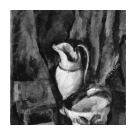

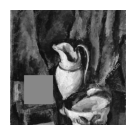

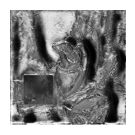

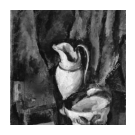

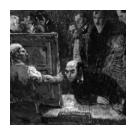

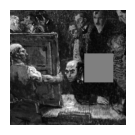

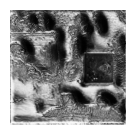

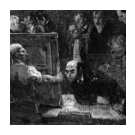

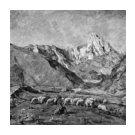

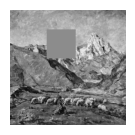

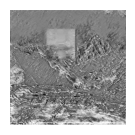

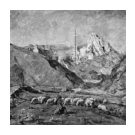

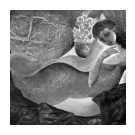

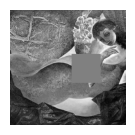

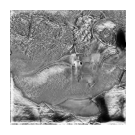

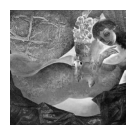

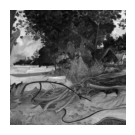

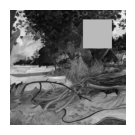

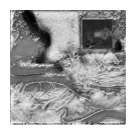

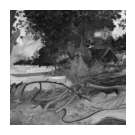

In [27]:
n_img = 0
n_imgs = 5
for i in range(n_img, n_img + n_imgs):
    gen_img = gan.generator(test_batch[0] * test_batch[1])[i]
    display_image(test_batch[0][i] * 0.5 + 0.5)
    display_image(test_batch[0][i] * (0.5 + 0.5 ) * test_batch[1][i])
    display_image(gen_img * (0.5 + 0.5 ))
    display_image((gen_img*(1-test_batch[1][i]) + test_batch[0][i] * test_batch[1][i]) * (0.5 + 0.5 ))

# ricorda di reimportare weights (epoche per ora: 3)

In [ ]:
# Train the GAN model on the dataset with specified parameters
run = wandb.init(
    project = "gan_ghog",
)

history = gan.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        GANMonitor(name='gan_ghog', gray=True, test_images = test_batch),
        
        WandbMetricsLogger(log_freq=10),
        # WandbModelCheckpoint(filepath="models/gan_ghog.keras")
    ],
).history

In [ ]:
from IPython.display import FileLink
FileLink(r'latest.weights.h5')

In [ ]:
display_image(gan.generator(test_batch[1]*test_batch[0])[1])
display_image(test_batch[0][1] * test_batch[1][1])
